<a href="https://colab.research.google.com/github/brian-ho/intro-to-urban-data/blob/main/Scale/S06_Organizing_and_presenting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **06 Scale**  Organizing and Presenting

```
    Class       ARCH 6131 Urban Design Methods / Skills / Tools 1
                The Gensler Family AAP NYC Center
                Fall 2024
                Monday 3:30 PM to 6 PM

    Instructor  Brian Ho
                brian@brian-ho.io
```

This notebook demonstrats ways to organize your data to enable visualization and presentation. We'll start by using an [example dataset](https://github.com/brian-ho/intro-to-urban-data/blob/main/example_data/brooklyn_city_vacant_lots.geojson) of vacant, city-owned lots in Brooklyn. But you are welcome to use your own dataset!

- Load and process a GeoDataFrame to simple geometry
- Transform geometry in Python
- Create a Rhino file and store GUIDs
- Save data files for use in Grasshopper

As always: let's start by connecting to Drive, setting up our data directory path, and importing the necessary dependencies.

In [1]:
# Connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# Set data directory path matching location in Google Drive
DATA_DIRECTORY = "../example_data"

In [ ]:
# Install rhino3dm for Colab noteboks
!pip install https://intro-to-urban-data.s3.amazonaws.com/rhino3dm-8.0.0b2-cp310-cp310-linux_x86_64.whl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.8 MB/s eta 0:00:00


In [2]:
# Load in dependencies
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import rhino3dm

## Explode a GeoDataFrame to simple geometry

We'll use a simple dataset of vacant, city-owned lots in Brooklyn. This is available in our [GitHub](https://github.com/brian-ho/intro-to-urban-data/blob/main/example_data/brooklyn_city_vacant_lots.geojson) — but you are encouraged to use a dataset of your own! We'll start by reading this dataset from a GeoJSON file on Google Drive.

In [7]:
# Load in the vacant lots from GeoJSON
vacant_lots_gdf = gpd.read_file(
    Path(DATA_DIRECTORY) / "brooklyn_city_vacant_lots.geojson"
)

# Lots in borough boundaries for context
boroughs_gdf = gpd.read_file(Path(DATA_DIRECTORY) / "Borough Boundaries.geojson")

We can get a sense of the data for reference.

In [8]:
print(f"There are {len(vacant_lots_gdf)} vacant lots in this dataset.")

There are 1008 vacant lots in this dataset.


The `matplotlib` library gives us the ability to have greater control over plotting. In this case, we can plot the boroughs in grey beneath the vacant lots. `subplots()` gives us a single set of plot axis we can re-use for various plots.

<Axes: >

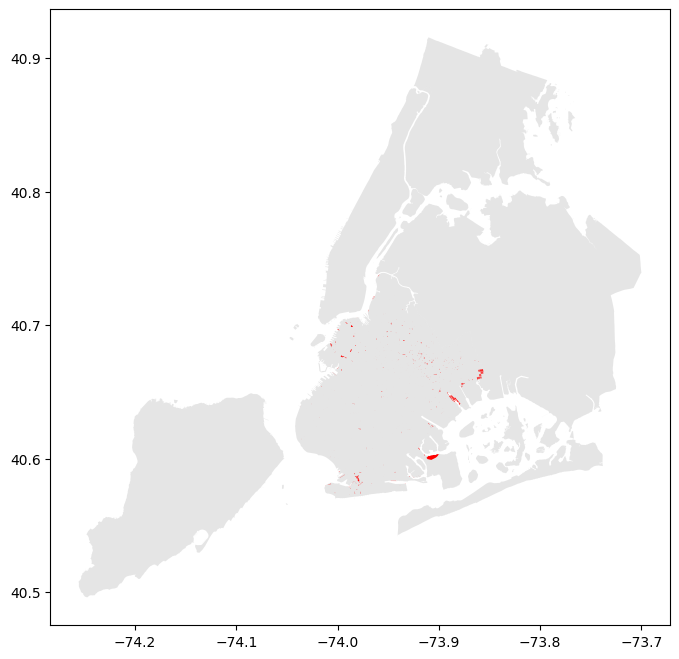

In [10]:
# Make a plot with multiple layers
_, ax = plt.subplots(figsize=(8, 8))
boroughs_gdf.plot(ax=ax, color="grey", alpha=0.2)
vacant_lots_gdf.plot(ax=ax, color="red")

In order to use the geometry for our purposes, we'll need to do two things:
1. Project this to a suitable CRS
2. Explode any multipolygon geometry to simple shapes

Projecting should be easy, building on previous tutorials.

In [11]:
# Project the data in place to the desired CRS
vacant_lots_gdf.to_crs(2263, inplace=True)

Multipolygon geometry are essentially groups of multiple independent polygons. Luckily, we can use the `geometry.type` attribute to filter by them. Let's start by checking how many multipolygon geometries there are.

In [12]:
# Check how many geometry there are of each type
vacant_lots_gdf.geometry.type.value_counts()

Polygon         978
MultiPolygon     30
Name: count, dtype: int64

It looks like about 3% of the lots have multipolygon geometry. Let's see their actual geometry:

<Axes: >

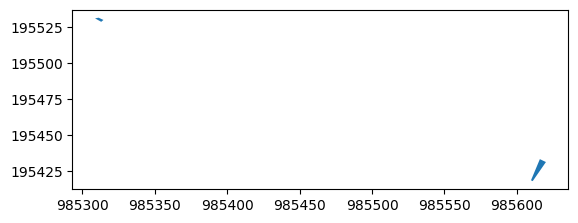

In [13]:
# Plot the first multipolygon gometry
vacant_lots_gdf[vacant_lots_gdf.geometry.type == "MultiPolygon"].head(1).plot()

Hmm ... these geometries seem quite small! It may be worth understanding the size of all the multipolygon lots.

<Axes: >

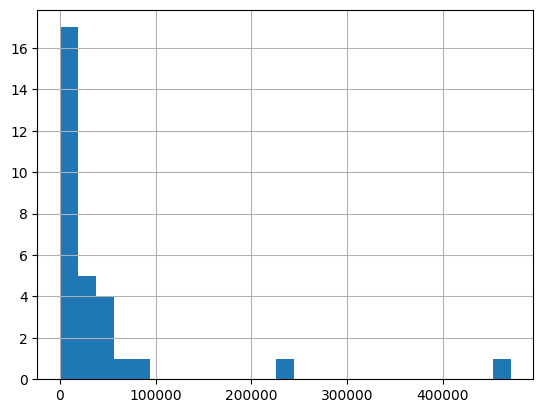

In [15]:
# Plot the first multipolygon gometry
vacant_lots_gdf[vacant_lots_gdf.geometry.type == "MultiPolygon"].geometry.area.hist(
    bins=25
)

Based on this, it looks like the vast majority of lots are smaller than 100,000 square feet (~2 acres). You may decide in your own work to filter out multipolygons and other small lots that can't be used.

In our case, we will explode them instead! This crease duplicate rows in the original GeoDataFrame, with one row for each part of the multipolygon.

In [16]:
# Exploding is pretty easy!
vacant_lots_exploded_gdf = vacant_lots_gdf.explode(index_parts=False)
print(
    f"There are {len(vacant_lots_exploded_gdf)} vacant lots in this exploded dataset."
)

There are 1060 vacant lots in this exploded dataset.


## Transform geometry in Python
In our dataset, each lot is still drawn as a geospatial feature — located where it is in NYC. As we work with our catalog's index and items, we may want to pull these lots into focus individually, and organize them as shapes.

The most basic operation will be to move each geometry so its center is (0, 0). We can do this by translating (moving) each geometry with an apply function. This time of geometric operation is known as an [affine transformation](https://shapely.readthedocs.io/en/stable/manual.html#affine-transformations), and we can use a specific module from Shapely to perform them.

In [17]:
# Import the translate function from Shapely
from shapely.affinity import translate


# Define our apply function
def move_to_origin(geom):
    """Takes in a geometry and moves it so that its centroid is at (0, 0)"""
    centroid = geom.centroid
    return translate(geom, xoff=-centroid.x, yoff=-centroid.y)

In [18]:
# Run the apply function to update the GeoDataFrame's geometry column
vacant_lots_exploded_gdf["geometry"] = vacant_lots_exploded_gdf["geometry"].apply(
    move_to_origin
)

With that done, we can preview the results to see if this worked!

<Axes: >

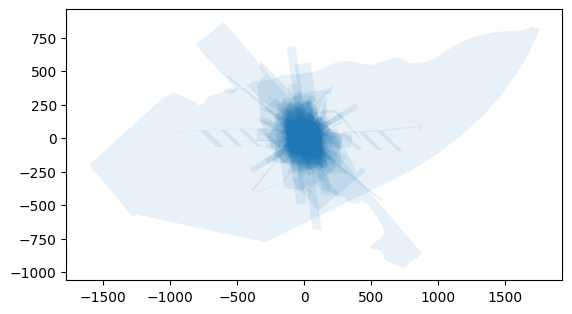

In [19]:
# This should plot each lot on top of each other.
vacant_lots_exploded_gdf.plot(alpha=0.1)

As a last step before we write out the file to Rhino, let's sort our data. Imagine we want to organize our data into lots by zip code. We may want to first sort by zip code, then by lot area.

We can do this with `sort_values()`, which allows us to pass in a list of sort columns.

In [20]:
vacant_lots_exploded_gdf.sort_values(
    by=["ZipCode", "LotArea"], ascending=[True, False], inplace=True
)

We can check the result of our sort by viewing just the relevant columns. We expect to see zip codes to be listed top-down smallest-largest, and lot areas to be top-down largest-smallest.

In [21]:
vacant_lots_exploded_gdf[["ZipCode", "LotArea"]]

,ZipCode,LotArea
817,0,680000
817,0,680000
984,0,240550
984,0,240550
984,0,240550
...,...,...
195,11249,20220
194,11249,17246
872,11249,13420
335,11249,6375


## Create a Rhino file and store GUIDs

Now that we've sorted our data, we're ready to write it to Rhino. In previous exercises, we've written this to Rhino as geospatial data using the actual coordinates. In this case, let's imagine we want to organize our lots into rows: where each row is zip code. And in each row, we can list the lots in order from largest to smallest. So something like:

```
zip code 1: big lot, medium lot, small lot
zip code 2: small lot, tiny lot
zip code 3: medium lot, tiny lot

```

To do this, we'll iterate in two loops: first by zip code, second by lot size. The sorting of the GeoDataFrame helps us with the order here. We'll then draw each lot in Rhino at an appropriate vertical and horizontal offset.


In [156]:
# Make an empty file and default layer
new_3dm = rhino3dm.File3dm()
new_3dm.Layers.AddLayer("Default", (255, 255, 255, 255))

# Create an empty list to store our generated GUIDs
guids = []

# We'll create colors for each layer
color_increment = 255 // len(vacant_lots_exploded_gdf["ZipCode"].unique())

# This outer loop iterates over each unique zip code in the dataset
for i, zip_code in enumerate(vacant_lots_exploded_gdf["ZipCode"].unique()):
    print(f"Adding layer for zip code {zip_code} ...", end="")

    color_value = i * color_increment
    zip_code_layer_index = new_3dm.Layers.AddLayer(
        f"ZIP {zip_code}", (0, 0, color_value, 255)
    )

    lots_in_zip_code = vacant_lots_exploded_gdf[
        vacant_lots_exploded_gdf["ZipCode"] == zip_code
    ]
    print(f" adding geometry {len(lots_in_zip_code)} lots.")

    # This inner loop iterates over each lot in that zip code
    for j, lot in enumerate(lots_in_zip_code.geometry):
        # We'll offset the position of the lot drawn in Rhino
        y_offset = i * 1500
        x_offset = j * 1500

        polyline_curve = rhino3dm.Polyline(
            [
                rhino3dm.Point3d(x + x_offset, y + y_offset, 0)
                for (x, y) in lot.exterior.coords
            ]
        ).ToPolylineCurve()

        attributes = rhino3dm.ObjectAttributes()
        attributes.LayerIndex = zip_code_layer_index
        guid = new_3dm.Objects.Add(polyline_curve, attributes)
        guids.append(guid)

vacant_lots_exploded_gdf["guid"] = guids

Adding layer for zip code 0 ... adding geometry 34 lots.
Adding layer for zip code 11201 ... adding geometry 10 lots.
Adding layer for zip code 11203 ... adding geometry 12 lots.
Adding layer for zip code 11204 ... adding geometry 7 lots.
Adding layer for zip code 11205 ... adding geometry 4 lots.
Adding layer for zip code 11206 ... adding geometry 42 lots.
Adding layer for zip code 11207 ... adding geometry 54 lots.
Adding layer for zip code 11208 ... adding geometry 99 lots.
Adding layer for zip code 11209 ... adding geometry 8 lots.
Adding layer for zip code 11210 ... adding geometry 8 lots.
Adding layer for zip code 11211 ... adding geometry 7 lots.
Adding layer for zip code 11212 ... adding geometry 74 lots.
Adding layer for zip code 11213 ... adding geometry 44 lots.
Adding layer for zip code 11214 ... adding geometry 15 lots.
Adding layer for zip code 11215 ... adding geometry 14 lots.
Adding layer for zip code 11216 ... adding geometry 24 lots.
Adding layer for zip code 11217 .

Save it out and take a look!

In [154]:
# Save the file. Make sure to check the version matches your version of Rhino.
new_3dm.Write("gridded_tax_lots.3dm", version=7)

True

## Save data files for use in Grasshopper
The next tutorial uses a Grasshopper script. We can save out a CSV for use there, dropping the geometry columnn and keeping the GUID information.

In [155]:
vacant_lots_exploded_gdf["guid"] = vacant_lots_exploded_gdf["guid"].astype(str)
vacant_lots_exploded_gdf.drop("geometry", axis=1).to_csv(
    "gridded_tax_lots.csv", sep=";"
)